# The effects of COVID-19 on crime rates in Vancouver

group project proposal:

Sean Lee, Neil Li, Tracy Wang, Wendi Zhong

## Introduction

Before the pandemic, our teammate Neil has experienced no crimes more major than perhaps public drunkeness, but once the pandemic started, he has been subjected to two different attempts of grand theft auto and one shooting. This can't help but make us wonder: is this simply a streak of bad luck or is there a genuine correlation between these crimes and the pandemic?

Now there are two ways to looking at this idea, as research (Nivette et. al., 2021) has shown that crime rate decreases due to lockdowns forcing people to stay in their homes, there are also arguments to be had about how the economic downturn (Munywoki, 2020) could lead more people into commiting crimes. So there are arguments for the pandemic leading people into commiting simultaneously less and more crimes.

### Research Question:

<b>Has Covid 19 affected the frequency and severity of Crimes?<b>
    
### Hypothesis:

$H_0: \mu_1 - \mu_2 = 0$ vs $H_1: \mu_1 - \mu_2 \neq 0$
    
$\mu_1$: the average total crimes commited before the outbreak
    
$\mu_2$: the average total crimes commited after the outbreak

In [1]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Dataset Info:

The dataset is downloaded from \"[Vancouver Crime Data](https://geodash.vpd.ca/opendata/)\", an open data dataset provided by the Vancouver Police Department. Which we selected to list all the the crimes commited in every neighbourhood in Vancouver since 2003.

In [2]:
crime_data <- read.csv("crimedata_csv_AllNeighbourhoods_AllYears.csv")
head(crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


Because we want to have the crime data be more representative of the difference between the years leading up to the pandemic to the years during and after the pandemic, we will filter the data to only include years from 2017 onwards, and before November since 2022 has not had a November yet. We will also only need the columns containing the type of the crime, year the crime was committed.

In [3]:
crime_data_processed <- crime_data %>%
    filter(YEAR >= 2017, MONTH <= 10) %>%
    select(TYPE, YEAR)

head(crime_data_processed)

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2019
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2021
4,Break and Enter Commercial,2020
5,Break and Enter Commercial,2022
6,Break and Enter Commercial,2022


In [4]:
# take a single sample with size 2000 from population

set.seed(2190)

crime_sample <- crime_data_processed %>%
    rep_sample_n(size = 2000, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))
head(crime_sample)

replicate,TYPE,YEAR,Pandemic
<int>,<chr>,<int>,<chr>
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Other Theft,2022,After
1,Mischief,2021,After
1,Theft of Bicycle,2017,Before


We first decided to visualize the overall spread of crime over the six years by taking a sample of size 2000, and bootstrapping 1000 samples from it to see the overall

In [5]:
# create 1000 bootstrap samples with size 2000 of the difference in crimes commited before the pandemic 
# (YEAR < 2020) 

set.seed(2190)
bootstrap_sample <- crime_sample %>%
    rep_sample_n(size = 2000, reps = 1000, replace = TRUE)%>%
    group_by(replicate,Pandemic)%>%
    summarize(n = n())%>%
    pivot_wider(names_from = Pandemic, values_from = n) %>%
    mutate(diff = Before - After) 
    
head(bootstrap_sample)

# calculate the mean of difference in crimes commited
sample_mean <- mean(bootstrap_sample$diff)
sample_mean

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,After,Before,diff
<int>,<int>,<int>,<int>
1,855,1145,290
2,838,1162,324
3,858,1142,284
4,887,1113,226
5,861,1139,278
6,817,1183,366


[1] 274.152

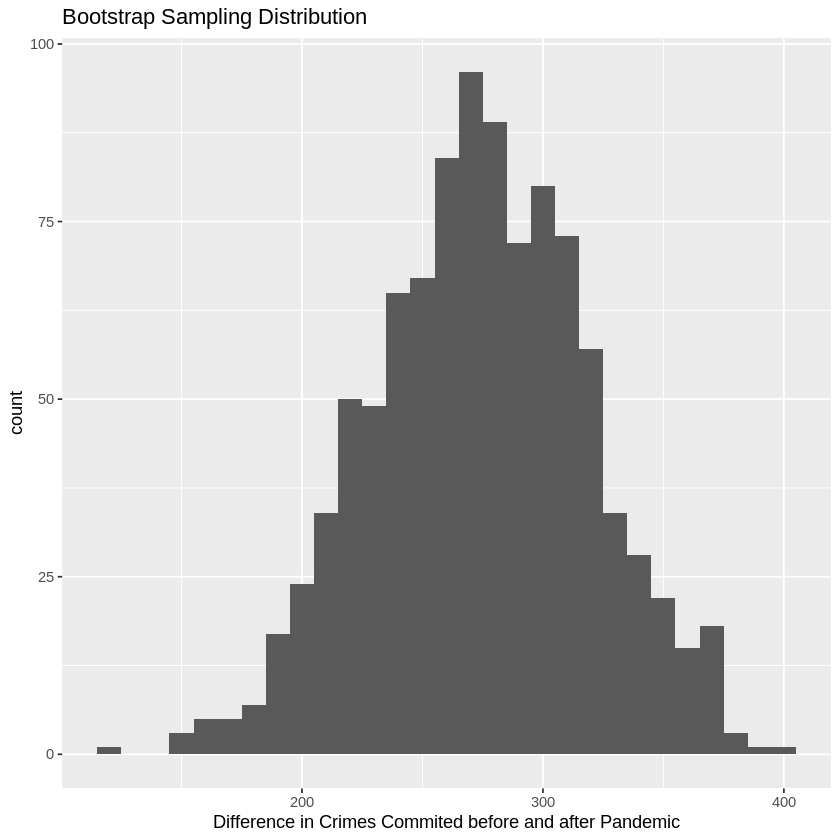

In [6]:
#Visualize the bootstrap distribution
bootstrap_sampling_distribution <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram(binwidth = 10) +
    xlab("Difference in Crimes Commited before and after Pandemic") +
    ggtitle("Bootstrap Sampling Distribution") 
    

bootstrap_sampling_distribution

In [7]:
#obtain 95% confidence interval 
ci <- bootstrap_sample %>%
    get_ci(level = 0.95, type = "percentile")
ci

lower_ci,upper_ci
<dbl>,<dbl>
188,364


Because this is a large dataset, we have the luxury of creating many large samples, and with those large samples we could apply the central limit theorem to get more crucial data.

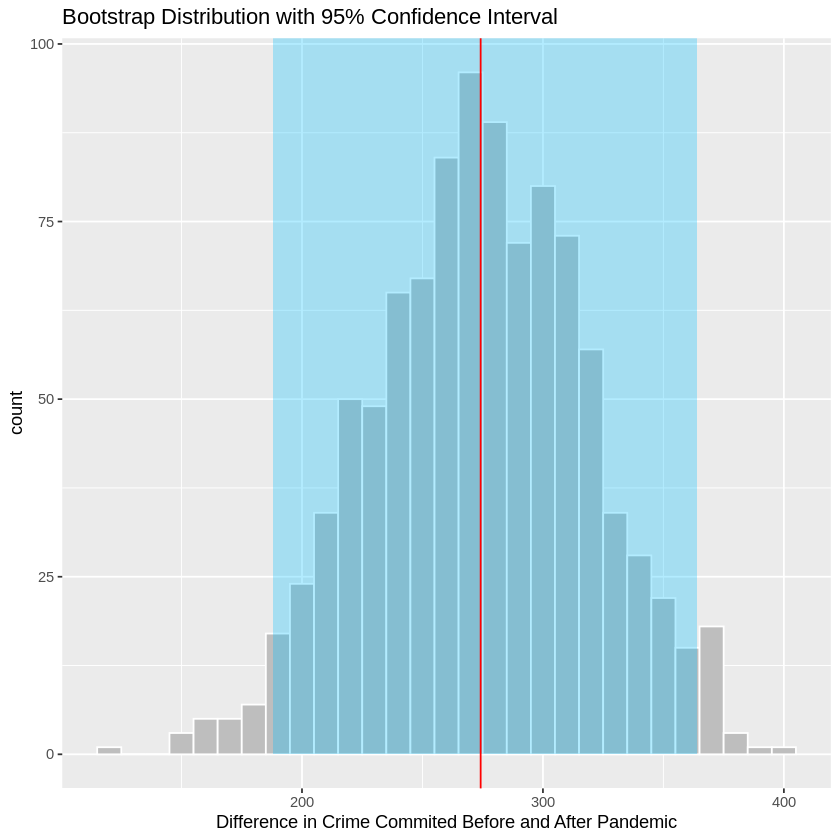

In [8]:
#Visualize the bootstrap distribution with 95% confidence interval

ci_plot <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram (binwidth = 10, colour = "white", fill = "grey") +
    annotate("rect", xmin = ci$lower_ci, xmax = ci$upper_ci, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    xlab("Difference in Crime Commited Before and After Pandemic")+
    ggtitle("Bootstrap Distribution with 95% Confidence Interval") +
    geom_vline(aes(xintercept= sample_mean), colour = "red")
    
ci_plot

In [9]:
# calculate mean and standard deviation on the difference between the total amount of 
# crime before and after the pandemic using the central limit theorem and obtain a 95% 
# confidence interval from this

In [10]:
# take 1000 single sample with size 2000 from population

set.seed(2190)

samples_CLT <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1000, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))

head(samples_CLT)

replicate,TYPE,YEAR,Pandemic
<int>,<chr>,<int>,<chr>
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Other Theft,2022,After
1,Mischief,2021,After
1,Theft of Bicycle,2017,Before


In [11]:
# calculate difference of crimes before and after 2020

diff_sampling_dist_CLT <- 
samples_CLT %>%
    group_by(replicate , Pandemic)%>%
    summarize(n = n()) %>%
    pivot_wider(names_from = Pandemic, values_from = n) %>%
    mutate(diff = Before - After) 

head(diff_sampling_dist_CLT)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,After,Before,diff
<int>,<int>,<int>,<int>
1,863,1137,274
2,858,1142,284
3,878,1122,244
4,878,1122,244
5,884,1116,232
6,871,1129,258


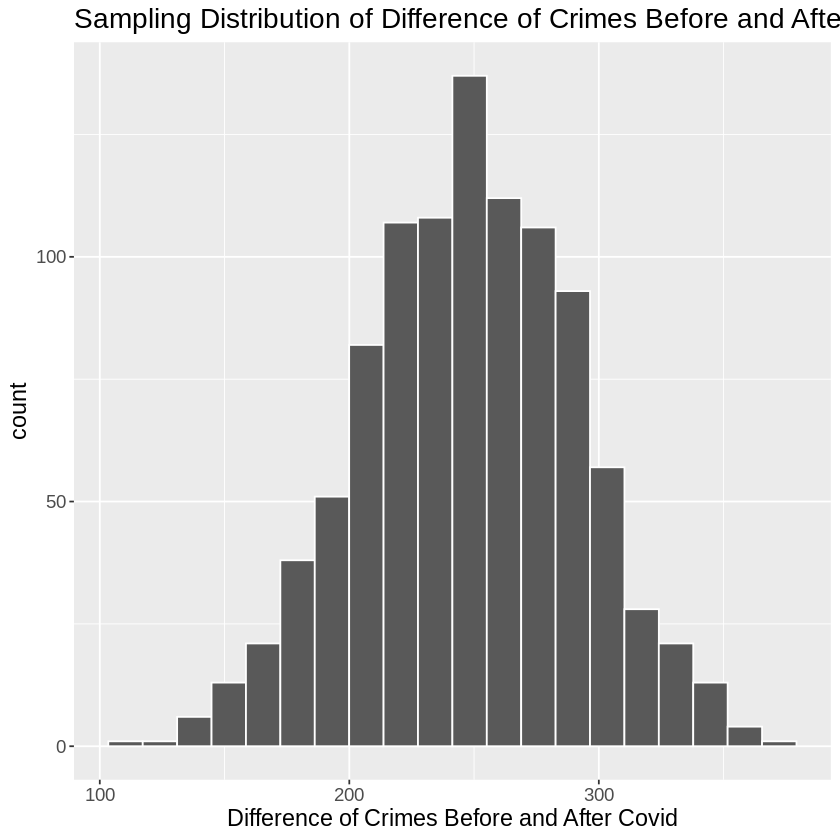

In [12]:
# Visualize size 2000 sampling distribution

diff_sampling_dist_plot_CLT <- 
diff_sampling_dist_CLT %>%
   ggplot(aes(x = diff)) +
   geom_histogram(bins = 20, color = 'white') +
   ggtitle("Sampling Distribution of Difference of Crimes Before and After Covid") +
   xlab("Difference of Crimes Before and After Covid") +
   theme(text = element_text(size = 14))

diff_sampling_dist_plot_CLT

In [13]:
# Get mean of sampling distribution
mean_CLT <- mean(diff_sampling_dist_CLT$diff)
mean_CLT

[1] 247.822

In [14]:
# Get 95% confidence interval
ci_CLT <- diff_sampling_dist_CLT %>%
            get_confidence_interval(type = "percentile", level = 0.95)
ci_CLT

lower_ci,upper_ci
<dbl>,<dbl>
161.95,334


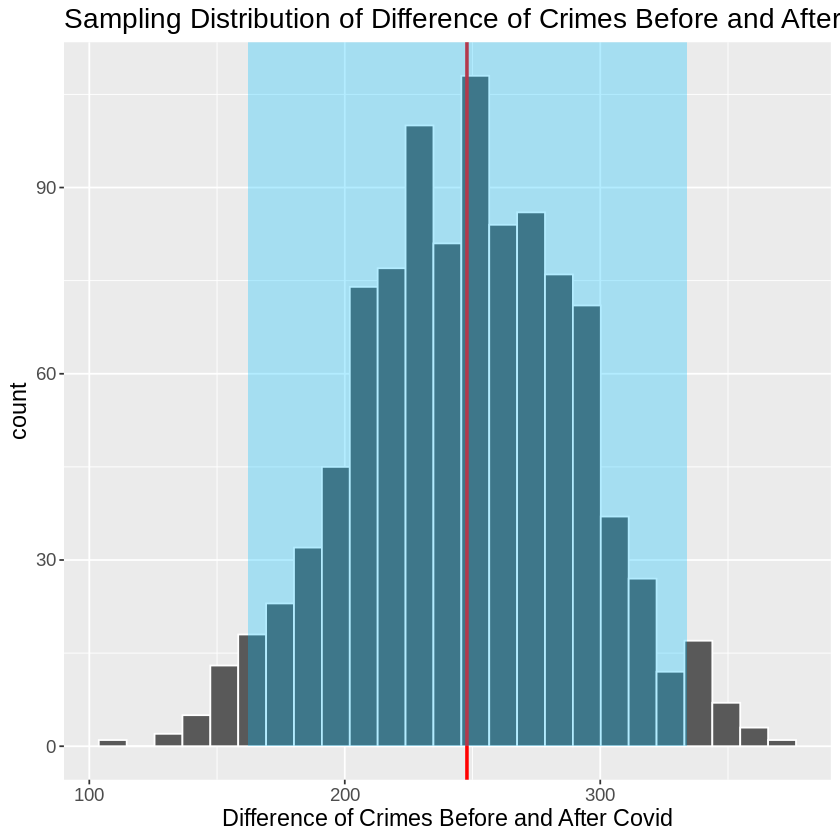

In [15]:
# lab mean on the sampling distribution
# shade 95% confidence interval on the sampling distribution

sample_quantile_plot <- 
    diff_sampling_dist_CLT %>% 
      ggplot(aes(x = diff)) +
      geom_histogram(bins = 25, color = 'white') +
      geom_vline(xintercept = mean_CLT, colour = "red", size = 1) +
      annotate("rect", 
              xmin = ci_CLT$lower_ci,
              xmax = ci_CLT$upper_ci,
              ymin = 0,
              ymax = Inf,
              fill = "deepskyblue",
              alpha = 0.3) +
      ggtitle("Sampling Distribution of Difference of Crimes Before and After Covid") +
      xlab("Difference of Crimes Before and After Covid") +
      theme(text = element_text(size = 14))

sample_quantile_plot

In [42]:
head(diff_sampling_dist_CLT)
# n of before & after
# mean of before & after
# var of before & after

# sd(diff_sampling_dist_CLT$diff)
# nrow(diff_sampling_dist_CLT)
# sqrt(nrow(diff_sampling_dist_CLT))


# size 1000, large enough so using normal model. 
# sample standard deviation is approximately equal to population standard deviation

sample_sd_CLT <- sd(diff_sampling_dist_CLT$diff)
std_error_CLT <- sample_sd_CLT/sqrt(1000)
z_CLT <- (mean_CLT-0)/std_error_CLT

tibble(sd = sample_sd_CLT,
       se = std_error_CLT,
       z_score = (mean_CLT-0)/std_error_CLT)

2* pnorm(z_CLT, lower.tail = FALSE)
2* pt(z_CLT, df=1000-1, lower.tail = FALSE)


replicate,After,Before,diff
<int>,<int>,<int>,<int>
1,863,1137,274
2,858,1142,284
3,878,1122,244
4,878,1122,244
5,884,1116,232
6,871,1129,258


sd,se,z_score
<dbl>,<dbl>,<dbl>
42.986,1.359337,182.311


[1] 0

[1] 0

mention our plans for hypothesis testing, and future plans to test how different kinds of crimes have been affected.

# References:

Ferguson, E. (2015). Crime and punishment vocabulary with pronunciation. IELTS Liz. Retrieved October 31, 2022, from https://ieltsliz.com/crime-and-punishment-vocabulary/ 

Munywoki, G. (2020). Economic effects of novel coronavirus (COVID – 19) on the global economy. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3719130 

n.a. (n.d.). Crime Data Download. VPD open data. Retrieved October 31, 2022, from https://geodash.vpd.ca/opendata/ 

Nivette, A.E., Zahnow, R., Aguilar, R. et al. A global analysis of the impact of COVID-19 stay-at-home restrictions on crime. Nat Hum Behav 5, 868–877 (2021). https://doi.org/10.1038/s41562-021-01139-z